### Using the Census API to grab international trade data.

This notebook explores the [Census international trade data](https://www.census.gov/data/developers/data-sets/international-trade.html). Unique features of this is that it can easily grab data monthy, by country, by sector, port, etc. The user manual is [here](https://www.census.gov/foreign-trade/reference/guides/Guide%20to%20International%20Trade%20Datasets.pdf). [Here](https://www.census.gov/foreign-trade/reference/release_schedule.html) is the data release schedual for which may be of use as things are updated by month. 

In [1]:
import pandas as pd # need this 
import matplotlib.pyplot as plt
import datetime as dt
import requests, io # internet and input tools  
import numpy as np
import os          

### Basic call: Aggregate Exports, by Month, Overtime

These replicate some of the calls in the .pdf file on the Census website. The basic approach to all of this is to specify the proper series/time and combine it with a key and then grab the file using the ``requests`` package.

In [2]:
my_key = "&key=34e40301bda77077e24c859c6c6c0b721ad73fc7"

url = "https://api.census.gov/data/timeseries/intltrade/exports/hs?get=ALL_VAL_MO" + my_key+"&time=from+2013-01"

Where the first part is just pointing to the correct website, then the second part says get all values, so this will be aggregate, then we do the key, then the time period. The notation ``from+2013-01`` grabs everything from 2013 onward.

In [48]:
r = requests.get(url) # This grabs the data which will be in json format

df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]
# This then grabs the labels and assigns them to be a column names.

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

df.set_index("time", inplace = True)

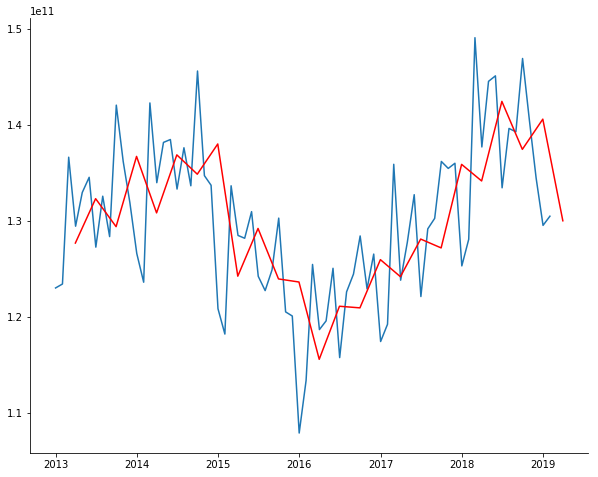

In [54]:
fig, ax = plt.subplots(figsize = (10,8))

ax.plot(df.ALL_VAL_MO)

ax.plot(df.ALL_VAL_MO.resample("q").mean(), color = 'r')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.show()

### Basic call: Exports by Country, All Years, by Month

This provides a rather comprehensive data set. Then the idea is to set the index by country and time and then we can easily slice this as we want 

In [326]:
url ="https://api.census.gov/data/timeseries/intltrade/exports/hs?get=CTY_CODE,CTY_NAME,ALL_VAL_MO" 

url = url + my_key

url = url + "&time=from+2013-01"

# CTY_CODE,CTY_NAME,ALL_VAL_MO grabs country code, name, all values
# The time part than grabls all time periods, by month

In [327]:
r = requests.get(url) # This grabs the data which will be in json format

df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

In [328]:
df.set_index(["CTY_NAME","time"], inplace = True)

In [329]:
df.head()

,,CTY_CODE,ALL_VAL_MO
CTY_NAME,time,,
NAFTA,2013-01-01,0020,4.107330e+10
OPEC,2013-01-01,0001,7.650292e+09
EUROPEAN UNION,2013-01-01,0003,2.025100e+10
PACIFIC RIM COUNTRIES,2013-01-01,0014,2.929276e+10
CAFTA-DR,2013-01-01,0017,2.283974e+09


This is nice now, we have all values, by country, by month, in a well organized dataframe

Now I'm going to make a nice annotated graphic showing how US exports to China have responded to the trade war.

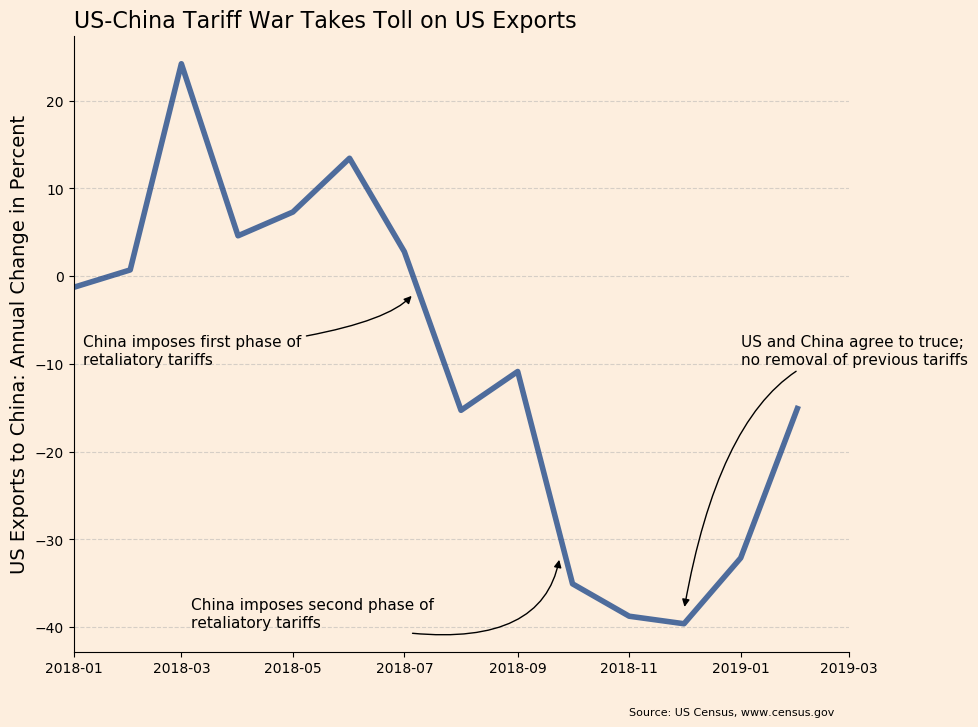

In [341]:
fig, ax = plt.subplots(figsize = (10,8))

background = tuple(np.array([253, 238, 222]) / 255)

mike_blue = tuple(np.array([20, 64, 134]) / 255)
### This is the FT background collor

fig.set_facecolor(background)
ax.set_facecolor(background)

plt.rcParams.update(plt.rcParamsDefault) # This will reset defaluts...

ax.plot(100*np.log(df.ALL_VAL_MO.loc["CHINA"]).diff(12), linewidth = 4, ls = "-", color = mike_blue, alpha =0.75)

#ax.plot(100*(df.ALL_VAL_MO.loc["CHINA"]).pct_change(12), linewidth = 4, ls = "-", color = mike_blue, alpha =0.75)

#ax.axhline(100*np.log(df.ALL_VAL_MO.loc["CHINA"]).diff(12).mean(), linewidth = 4, ls = "--", color = 'k', alpha =0.5)

#ax.axvline(dt.datetime(2018,7,6), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

#ax.axvline(dt.datetime(2018,8,23), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

#ax.axvline(dt.datetime(2018,12,1), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

#ax.plot(np.log(df.ALL_VAL_MO.loc["CHINA"]).diff(12).resample("q").mean(), color = 'r')

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

ax.set_ylabel("US Exports to China: Annual Change in Percent", fontsize = 14)

ax.set_title("US-China Tariff War Takes Toll on US Exports", fontsize = 16, loc= "left" )

###################################################################################
ax.annotate(
    "China imposes first phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,7,6), -2), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,1,6), -10), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=50",
        "color": "black"
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "China imposes second phase of\nretaliatory tariffs", 
    xy=(dt.datetime(2018,9,24), -32), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2018,3,6), -40), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=345,angleB=80",
        "color": "black"
    },
    fontsize=11,
)

###################################################################################

ax.annotate(
    "US and China agree to truce; \nno removal of previous tariffs", 
    xy=(dt.datetime(2018,12,1), -38), # This is where we point at...
    xycoords="data", # Not exactly sure about this
    xytext=(dt.datetime(2019,1,1), -10), # This is about where the text is
    horizontalalignment="left", # How the text is alined
    arrowprops={
        "arrowstyle": "-|>", # This is stuff about the arrow
        "connectionstyle": "angle3,angleA=5,angleB=80",
        "color": "black"
    },
    fontsize=11,
)

ax.yaxis.grid(alpha= 0.5, linestyle= "--")

ax.text(dt.datetime(2018,11,1),-50, "Source: US Census, " 
        "www.census.gov", fontsize = 8)

###################################################################################

plt.savefig("us_china_trade_war.pdf", bbox_inches = "tight", dip = 3600, facecolor=background)

plt.show()

### Trade data broken down by commodity classification

In [214]:
end_use = "naics?get=NAICS,CTY_CODE,CTY_NAME,ALL_VAL_MO"

# Here this is saying, by nics, get country code, name, all values by month, by year, 


url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time=2019-01" + "&COMM_LVL=NA2"

# where the last part grabs this by commodity level here NA2

In [224]:
r = requests.get(url) 

df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

df.head()

,NAICS,CTY_CODE,CTY_NAME,ALL_VAL_MO,time,COMM_LVL
0,11,-,TOTAL FOR ALL COUNTRIES,6.293106e+09,2019-01-01,NA2
1,11,0001,OPEC,2.388274e+08,2019-01-01,NA2
2,11,0003,EUROPEAN UNION,8.514826e+08,2019-01-01,NA2
3,11,0014,PACIFIC RIM COUNTRIES,2.071330e+09,2019-01-01,NA2
4,11,0017,CAFTA-DR,1.578516e+08,2019-01-01,NA2


### Trade data broken down by commodity classification, overtime, one country

We will do this for China

In [255]:
end_use = "naics?get=NAICS,CTY_CODE,ALL_VAL_MO,CTY_NAME"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time==from+2013-01" + "&COMM_LVL=NA3"

url = url + "&CTY_CODE=5700"

In [256]:
r = requests.get(url) 

In [257]:
r

<Response [400]>

In [231]:
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

df.head(25)

,NAICS,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE
0,111,5700,2.287526e+09,CHINA,2013-01-01,NA3,5700
1,112,5700,1.199540e+07,CHINA,2013-01-01,NA3,5700
2,113,5700,6.061416e+07,CHINA,2013-01-01,NA3,5700
3,114,5700,2.962940e+07,CHINA,2013-01-01,NA3,5700
4,211,5700,2.734028e+07,CHINA,2013-01-01,NA3,5700
5,212,5700,2.157284e+08,CHINA,2013-01-01,NA3,5700
6,311,5700,3.337977e+08,CHINA,2013-01-01,NA3,5700
7,312,5700,4.481010e+07,CHINA,2013-01-01,NA3,5700
8,313,5700,4.572768e+07,CHINA,2013-01-01,NA3,5700
9,314,5700,3.261136e+06,CHINA,2013-01-01,NA3,5700


In [252]:
df.set_index(["NAICS","time"], inplace = True)

In [254]:
naics_list = ["111", "112"]

df.loc[naics_list]

,,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE
NAICS,time,,,,,
111,2013-01-01,5700,2.287526e+09,CHINA,NA3,5700
112,2013-01-01,5700,1.199540e+07,CHINA,NA3,5700
111,2013-02-01,5700,2.046730e+09,CHINA,NA3,5700
112,2013-02-01,5700,6.740946e+06,CHINA,NA3,5700
111,2013-03-01,5700,1.195718e+09,CHINA,NA3,5700
112,2013-03-01,5700,1.415156e+07,CHINA,NA3,5700
111,2013-04-01,5700,4.469944e+08,CHINA,NA3,5700
112,2013-04-01,5700,7.337108e+07,CHINA,NA3,5700
111,2013-05-01,5700,3.309472e+08,CHINA,NA3,5700


### BY HS code

In [3]:
end_use = "hs?get=E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,NAICS"

url = "https://api.census.gov/data/timeseries/intltrade/exports/" + end_use + my_key + "&time=2013-01" + "&COMM_LVL=HS6"

url = url + "&CTY_CODE=5700"

In [4]:
r = requests.get(url) 

r

<Response [400]>

In [269]:
df = pd.DataFrame(r.json()[1:]) # This then converts it to a dataframe
# Note that the first entry is the labels

df.columns = r.json()[0]

df.time = pd.to_datetime(df.time)

df.ALL_VAL_MO = df.ALL_VAL_MO.astype(float)

df.head()

,E_COMMODITY,CTY_CODE,ALL_VAL_MO,CTY_NAME,time,COMM_LVL,CTY_CODE
0,481031,5700,287000.0,CHINA,2013-01-01,HS6,5700
1,481160,5700,311650.0,CHINA,2013-01-01,HS6,5700
2,481620,5700,63701.0,CHINA,2013-01-01,HS6,5700
3,490290,5700,40265.0,CHINA,2013-01-01,HS6,5700
4,480431,5700,324939.0,CHINA,2013-01-01,HS6,5700


In [272]:
df.set_index(["E_COMMODITY","time"], inplace = True)

In [273]:
df.head()

,,CTY_CODE,ALL_VAL_MO,CTY_NAME,COMM_LVL,CTY_CODE
E_COMMODITY,time,,,,,
481031,2013-01-01,5700,287000.0,CHINA,HS6,5700
481160,2013-01-01,5700,311650.0,CHINA,HS6,5700
481620,2013-01-01,5700,63701.0,CHINA,HS6,5700
490290,2013-01-01,5700,40265.0,CHINA,HS6,5700
480431,2013-01-01,5700,324939.0,CHINA,HS6,5700


(-100, 100)

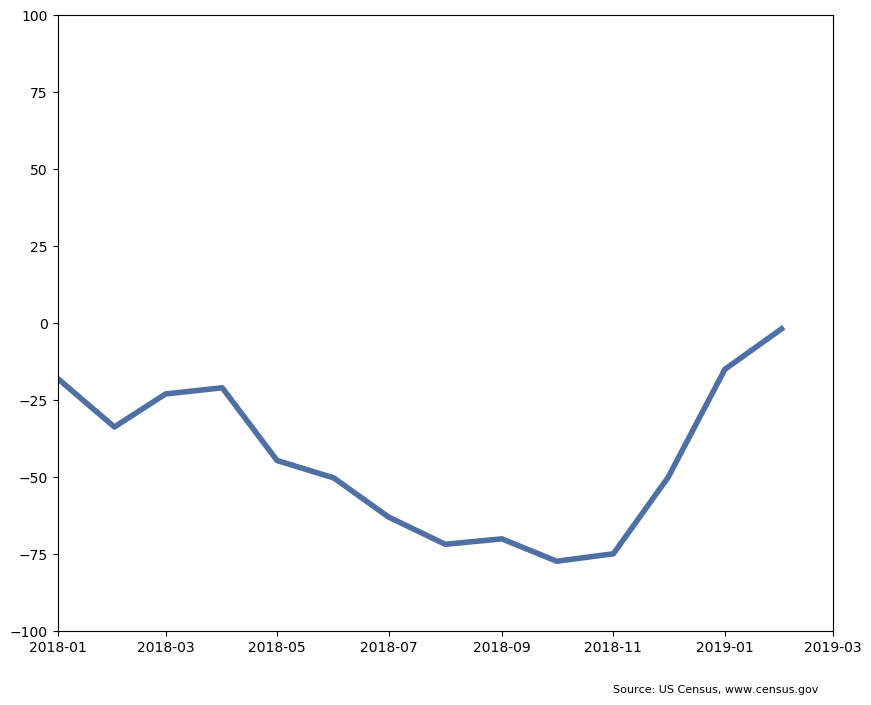

In [325]:
soybeans = "020649"


fig,ax = plt.subplots(figsize = (10,8))

ax.plot(100*df.ALL_VAL_MO.loc[soybeans].pct_change(12), linewidth = 4, ls = "-", color = mike_blue, alpha =0.75)

#ax.axhline(100*np.log(df.ALL_VAL_MO.loc["CHINA"]).diff(12).mean(), linewidth = 4, ls = "--", color = 'k', alpha =0.5)

#ax.axvline(dt.datetime(2018,7,6), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

#ax.axvline(dt.datetime(2018,8,23), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

#ax.axvline(dt.datetime(2018,12,1), linewidth = 4, ls = "--", color = 'k', alpha =0.25)

ax.set_xlim(dt.datetime(2018,1,1),dt.datetime(2019,3,1))

ax.text(dt.datetime(2018,11,1),-120, "Source: US Census, " 
        "www.census.gov", fontsize = 8)

ax.set_ylim(-100,100)